In [7]:
from collections import defaultdict
import math
import pandas as pd
import re
from datetime import datetime 
import numpy as np
from decimal import Decimal
import matplotlib.pyplot as plt
import pylab

print('numpy: ',np.version.version)
print('pandas: ',pd.__version__)

numpy:  1.17.2
pandas:  1.0.3


In [8]:
languages = ['eu', 'ca', 'gl', 'es', 'en', 'pt']
defaultSmoothing = 10e-10
for language in languages:
    exec("%sCount=0" % language)
    exec("%sAlphabets={}" % language)
    exec('%sSize = 0' % language)
    exec('%sModel = np.array([])' % language)
    exec('%snewModel = np.array([])' % language)

In [9]:
df = pd.read_csv('../OriginalDataSet/training-tweets.txt', encoding='utf-8', error_bad_lines=False, sep='\t', warn_bad_lines=False) #nrows=5000,
df.columns = ['TweetID', 'UserID', 'Language', "Tweet"]
_df = df[['Language', 'Tweet']].copy()
train_dict = defaultdict(list)
pattern = re.compile('[a-z]')
# _df0.head()
start_time = datetime.now() 
for index, row in _df.iterrows():
    sentence = ''
    tweet = row['Tweet']
    tweet = tweet.lower()
    language = row['Language']
    exec('%sCount += 1' % language)
    for letter in tweet:
        if pattern.match(letter):
            exec('if \'{let}\' not in {L}Alphabets.keys():\n\
                     {L}Alphabets[letter] = {L}Size\n\
                     {L}Size += 1'.format(let=letter, L=language))
            sentence = sentence + letter
        else:
            sentence = sentence + ' '
    train_dict[row['Language']].append(sentence)
print('Reading time (hh:mm:ss.ms) {}'.format(datetime.now() - start_time ))

Reading time (hh:mm:ss.ms) 0:00:35.267775


In [10]:
# print(enAlphabets)
# exec('%sAlphabets = dict( sorted(%sAlphabets.items(), key=lambda x: x[0].lower()) )'%(lan))
# print(sortedDict)

# UNIGRAMS

In [11]:
for language in languages:
    exec("{L}Model = np.resize({L}Model, ({L}Size+1))".format(L=language))
    
    exec('{L}Model = np.add({L}Model, defaultSmoothing)'.format(L=language))


start_time = datetime.now()
delta = 0.5
for language, tweets in train_dict.items():
    for tweet in tweets:
        for i in range(len(tweet) - 1):
            first = tweet[i] # get the first character
            if not first.isspace():
                exec('index = %sAlphabets[first]' % language)  # get index of the character from the language dictionary
                exec('%sModel[index] += 1' % language)
for language in languages:
    exec('%sModel = np.add(%sModel, delta)'%(language, language)) #this is where smoothing happens
    exec('%sModel = np.divide(%sModel, %sModel.sum(axis=0))'%(language, language, language)) #divide all the values by the sum of the row
    exec('%sModel = np.log10(%sModel)'%(language, language))
print('Training time (hh:mm:ss.ms) {}'.format(datetime.now() - start_time ))

Training time (hh:mm:ss.ms) 0:00:27.376496


In [20]:
dictA = {'a':0,'b':1,'c':2,'d':3,'e':4,'f':5,'g':6,'h':7,'i':8,'j':9,'k':10,'l':11,'m':12,'n':13,'o':14,'p':15,'q':16,'r':17,'s':18,'t':19,'u':20,'v':21,'w':22,'x':23,'y':24,'z':25 }
for language in languages:
    exec("{L}newModel = np.resize({L}Model, ({L}Size))".format(L=language))
    for key, value in dictA.items():
        exec('index = %sAlphabets[key]'%(language))
        exec('%snewModel[value] = %sModel[index]'%(language, language))

In [21]:
print(esModel.shape)
# print(esAlphabets)
print(esnewModel.shape)

(27,)
(26,)


In [ ]:
for language in languages:    
    exec ( 'x = np.asarray(list(dictA.values()))\n\
y = {L}newModel\n\
fig = plt.figure()\n\
fig.set_size_inches(15, 3)\n\
colors = np.random.rand(x.shape[0])\n\
plt.title(\'{L}\')\n\
plt.xlabel(\'Alphabets\')\n\
plt.ylabel(\'Probability of alphabet\')\n\
plt.scatter(x, y, c=colors, alpha=0.9)\n\
plt.xticks(x, list(dictA.keys()))\n\
plt.tick_params(axis=\'x\', which=\'minor\', labelsize=10, width = 5)'.format(L=language) )

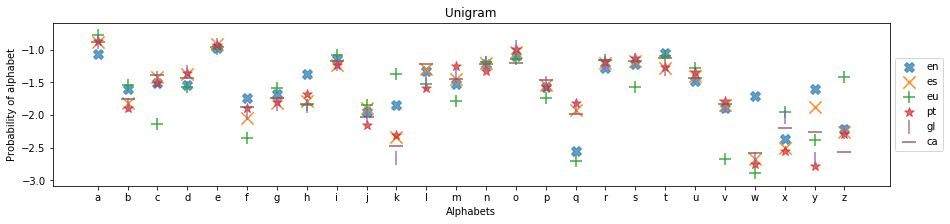

In [55]:
x = np.asarray(list(dictA.values()))
y1 = ennewModel
y2 = esnewModel
y3 = eunewModel
y4 = ptnewModel
y5 = glnewModel
y6 = canewModel

fig = plt.figure()
ax = plt.subplot(111)
fig.set_size_inches(15, 3)
area = 250
# colors = np.random.rand(x.shape[0])
plt.title('Unigram')
plt.xlabel('Alphabets')
plt.ylabel('Probability of alphabet')
plt.scatter(x, y1, s=100, alpha=0.7, marker='X', label='en')
plt.scatter(x, y2, s=150, alpha=0.9, marker='x', label='es')
plt.scatter(x, y3, s=150, alpha=0.9, marker='+', label='eu')
plt.scatter(x, y4, s=100, alpha=0.7, marker='*', label='pt')
plt.scatter(x, y5, s=200, alpha=0.9, marker='|', label='gl')
plt.scatter(x, y6, s=200, alpha=0.9, marker='_', label='ca')
plt.xticks(x, list(dictA.keys()))
plt.tick_params(axis='x', which='minor', labelsize=10, width = 5)

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

# plt.savefig('Unigram.png', dpi=150, bbox_inches='tight')

# BIGRAMS

In [ ]:
for language in languages:
    exec("%sModel=np.zeros(shape=((%sSize+1),(%sSize+1))) " %(language, language, language))
    exec('{L}Model = np.add({L}Model, defaultSmoothing)'.format(L=language))
    
start_time = datetime.now()
delta = 0
for language, tweets in trainDict.items():
    for tweet in tweets:
        for i in range(len(tweet)-2):
            first = tweet[i]
            second = tweet[i+1]
            exec('firstIndex = %sAlphabets[first]'%(language))
            exec('secondIndex = %sAlphabets[second]'%(language))
            exec('%sModel[firstIndex][secondIndex] += 1'%(language))
# here the Model.sum(axis=1) instead of axis=0 for uni/trigrams. Helps to avoid haveing a loop for every row of 2D array.
for language in languages:
    exec('%sModel = np.add(%sModel, delta)'%(language, language)) #this is where smoothing happens
    exec('%sModel = %sModel/%sModel.sum(axis=1)'%(language, language, language)) #divide all the values by the sum of the row
    exec('%sModel = np.log10(%sModel)'%(language, language))
print('Training time (hh:mm:ss.ms) {}'.format(datetime.now() - start_time ))

## SAVE MODEL FOR 1D OR 2D

```python
for language in languages:
    exec('np.savetxt(\'{L}ModelBigram.model\', {L}Model, delimiter=\',\', fmt=\'%1.2e\')'.format(L=language))
``` 

In [ ]:
for language in languages:
    exec('np.savetxt(\'{L}ModelBigram.model\', {L}Model, delimiter=\',\', fmt=\'%1.2e\')'.format(L=language))

# TRIGRAMS

In [ ]:
for language in languages:
    exec('{lang}Model=np.zeros(shape=(({lang}Size+1),({lang}Size+1),({lang}Size+1)))'.format(lang=language))#, language, language, language))
    exec('{L}Model = np.add({L}Model, defaultSmoothing)'.format(L=language))
    
start_time = datetime.now()
delta = 0.5
for language, tweets in trainDict.items():
    for tweet in tweets:
        for i in range(len(tweet)-2):
            first = tweet[i]
            second = tweet[i+1]
            third = tweet[i+2]
            exec('firstIndex = %sAlphabets[first]'%(language))
            exec('secondIndex = %sAlphabets[second]'%(language))
            exec('thirdIndex = %sAlphabets[third]'%(language))
            exec('%sModel[firstIndex][secondIndex][thirdIndex] += 1'%(language))
for language in languages:
    exec('for x in range({lang}Model.shape[0]):\n\
    for y in range({lang}Model.shape[1]):\n\
        {lang}ModelTemp = {lang}Model[x,y,:]\n\
        {lang}ModelTemp = np.add({lang}ModelTemp, delta)\n\
        {lang}ModelTemp = np.divide({lang}ModelTemp, {lang}ModelTemp.sum(axis=0))\n\
        {lang}ModelTemp = np.log10({lang}ModelTemp)\n\
        {lang}Model[x,y,:] = {lang}ModelTemp\n'.format(lang=language))

print('Training time (hh:mm:ss.ms) {}'.format(datetime.now() - start_time ))

## SAVE MODEL FOR 3D

```python
for language in languages:
    exec('outfile = open(\'{L}ModelTrigram.model\', \'w\')\n\
    print(\'# Shape \', {L}Model.shape, file=outfile)\n\
    outfile.flush()\n\
    print(\'# To load model - new_data = np.loadtxt(filename)\', file=outfile)\n\
    outfile.flush()\n\
    print(\'# Reshape the data - new_data = new_data.reshape((shape))\', file=outfile)\n\
    outfile.flush()\n\
    for data_slice in {L}Model:\n\
        np.savetxt(outfile, data_slice, delimiter=\',\', fmt=\'%1.2e\')'.format(L=language))
``` 

# PLOTTING UNIGRAM MODEL

x:
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77]
dict_keys(['I', 'M', ' ', 'C', 'O', 'N', 'F', 'U', 'S', 'E', 'D', 'W', 'H', 'A', 'T', 'R', 'L', 'J', 'j', 'u', 's', 't', 'i', 'n', 'b', 'e', 'r', 'a', 'f', 'o', 'd', 'y', 'p', 'h', 'P', 'm', 'l', 'c', 'Q', 'Z', 'B', 'z', 'v', 'g', 'k', 'w', 'Y', 'x', 'K', 'V', 'X', 'q', 'G', 'á', 'ñ', 'Ú', 'í', 'è', 'ó', 'ü', 'é', 'ç', 'ã', 'à', 'ā', 'ò', 'б', 'а', 'р', 'с', 'е', 'л', 'о', 'н', 'É', 'º', 'Ó'])
y:
 [ -1.96660524  -2.22401122  -0.80594876  -2.36989872  -2.2723159
  -2.34060934  -2.45518256  -2.50967682  -2.00264395  -2.07224846
  -2.43321356  -2.36654507  -2.36821866  -2.13707983  -2.0816807
  -2.29721858  -2.18823236  -2.40130718  -2.2790913   -1.61008452
  -1.38479614  -1.17578253  -1.30584723  -1.3387252   -1.77590898
  -1.09658334  -1.40952751  

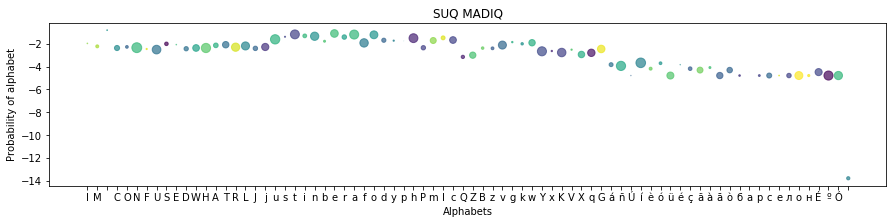

In [8]:
x = np.asarray(list(enAlphabets.values()))
x = np.append(x, (x.shape[0]))
y = enModel
print('x:\n', x)
print(enAlphabets.keys())
print('y:\n', y)

fig = plt.figure()
fig.set_size_inches(15, 3)
area = (10 * np.random.rand(x.shape[0]))**2
colors = np.random.rand(x.shape[0])
plt.title('SUQ MADIQ')
plt.xlabel('Alphabets')
plt.ylabel('Probability of alphabet')
plt.scatter(x, y, s=area, c=colors, alpha=0.7)
plt.xticks(x, list(enAlphabets.keys()))
plt.tick_params(axis='x', which='minor', labelsize=10, width = 5)